# Embedding Analysis: Within-Patient Cross-Modality Distances

Analyzes how close/far different modalities are for the same patient across 4 checkpoints.

In [55]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

plt.rcParams.update({'font.size': 10, 'figure.dpi': 100, 'savefig.dpi': 300})
print('Imports successful!')

Imports successful!


## Load All Embeddings

In [56]:
BASE_DIR = Path('/results/mgazda/embeddings_analysis')

checkpoint_names = ['mcl', 'cl', 'mae_mcl', 'mae_cl']
checkpoint_labels = {'mcl': 'MCL', 'cl': 'CL', 'mae_mcl': 'MAE + MCL', 'mae_cl': 'MAE + CL'}

embeddings_dict = {}
metadata_dict = {}

for name in checkpoint_names:
    checkpoint_dir = BASE_DIR / name
    embeddings_dict[name] = torch.load(checkpoint_dir / 'embeddings.pt')
    metadata_dict[name] = pd.read_csv(checkpoint_dir / 'metadata.csv')
    
    print(f'{checkpoint_labels[name]}:')
    print(f'  Shape: {embeddings_dict[name].shape}')
    print(f'  Patients: {metadata_dict[name]["patient_id"].nunique()}')
    print(f'  Modalities: {sorted(metadata_dict[name]["modality"].unique())}\n')

MCL:
  Shape: torch.Size([1159, 768])
  Patients: 177
  Modalities: ['dwi', 'flair', 'pd', 't1', 't2']

CL:
  Shape: torch.Size([1159, 768])
  Patients: 177
  Modalities: ['dwi', 'flair', 'pd', 't1', 't2']

MAE + MCL:
  Shape: torch.Size([1159, 768])
  Patients: 177
  Modalities: ['dwi', 'flair', 'pd', 't1', 't2']

MAE + CL:
  Shape: torch.Size([1159, 768])
  Patients: 177
  Modalities: ['dwi', 'flair', 'pd', 't1', 't2']



## Within-Patient Cross-Modality Distance Analysis

For each patient, compute average distance between all pairs of different modalities.
- **Lower distance** = More modality-agnostic
- **Higher distance** = More modality-specific

In [57]:
within_patient_results = []

for checkpoint_name in checkpoint_names:
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    print(f'Processing {checkpoint_labels[checkpoint_name]}...')
    
    for patient_id in metadata['patient_id'].unique():
        patient_mask = metadata['patient_id'] == patient_id
        patient_data = metadata[patient_mask]
        patient_indices = patient_data.index.tolist()
        
        if len(patient_indices) < 2:
            continue
        
        patient_embeddings = embeddings[patient_indices]
        patient_modalities = patient_data['modality'].values
        
        cosine_distances = []
        l2_distances = []
        
        for i, j in combinations(range(len(patient_indices)), 2):
            if patient_modalities[i] != patient_modalities[j]:
                cos_sim = cosine_similarity(patient_embeddings[i:i+1], patient_embeddings[j:j+1])[0, 0]
                cosine_distances.append(1 - cos_sim)
                l2_distances.append(np.linalg.norm(patient_embeddings[i] - patient_embeddings[j]))
        
        if len(cosine_distances) == 0:
            continue
        
        within_patient_results.append({
            'checkpoint': checkpoint_labels[checkpoint_name],
            'patient_id': patient_id,
            'n_modalities': len(set(patient_modalities)),
            'n_scans': len(patient_indices),
            'n_cross_modality_pairs': len(cosine_distances),
            'avg_cosine_distance': np.mean(cosine_distances),
            'std_cosine_distance': np.std(cosine_distances),
            'avg_l2_distance': np.mean(l2_distances),
            'std_l2_distance': np.std(l2_distances),
        })

df_within_patient = pd.DataFrame(within_patient_results)

print(f'\nComputed within-patient distances for {len(df_within_patient)} patient-checkpoint combinations')
print(f'Unique patients analyzed: {df_within_patient["patient_id"].nunique()}')
print(f'\nFirst few rows:')
print(df_within_patient.head(10))

Processing MCL...
Processing CL...
Processing MAE + MCL...
Processing MAE + CL...

Computed within-patient distances for 588 patient-checkpoint combinations
Unique patients analyzed: 147

First few rows:
  checkpoint  patient_id  n_modalities  n_scans  n_cross_modality_pairs  \
0        MCL        7044             2       10                      25   
1        MCL        1272             3        6                      11   
2        MCL         566             2        3                       2   
3        MCL        4551             2        6                       5   
4        MCL        7727             2        6                       5   
5        MCL        2584             3        6                      11   
6        MCL        8469             2       10                      25   
7        MCL        5433             2       10                      25   
8        MCL        5680             2       18                      45   
9        MCL       10244             2        

## Summary Statistics

In [58]:
print('='*80)
print('WITHIN-PATIENT CROSS-MODALITY DISTANCES')
print('='*80)
print('(Lower = More modality-agnostic, Higher = More modality-specific)')
print('='*80)

checkpoint_summary = df_within_patient.groupby('checkpoint').agg({
    'avg_cosine_distance': ['mean', 'std'],
    'avg_l2_distance': ['mean', 'std'],
    'patient_id': 'count',
}).round(4)

print('\nAverage across all patients:\n')
for checkpoint_name in [checkpoint_labels[name] for name in checkpoint_names]:
    if checkpoint_name in checkpoint_summary.index:
        stats = checkpoint_summary.loc[checkpoint_name]
        print(f'{checkpoint_name}:')
        print(f'  Cosine Distance: {stats[("avg_cosine_distance", "mean")]:.4f} ± {stats[("avg_cosine_distance", "std")]:.4f}')
        print(f'  L2 Distance:     {stats[("avg_l2_distance", "mean")]:.4f} ± {stats[("avg_l2_distance", "std")]:.4f}')
        print(f'  Patients analyzed: {int(stats[("patient_id", "count")])}')
        print()

print('='*80)

cosine_means = {cp: checkpoint_summary.loc[cp][('avg_cosine_distance', 'mean')] for cp in checkpoint_summary.index}
most_agnostic = min(cosine_means, key=cosine_means.get)
most_specific = max(cosine_means, key=cosine_means.get)

print(f'\nMost modality-agnostic (lowest distance): {most_agnostic}')
print(f'Most modality-specific (highest distance): {most_specific}')

WITHIN-PATIENT CROSS-MODALITY DISTANCES
(Lower = More modality-agnostic, Higher = More modality-specific)

Average across all patients:

MCL:
  Cosine Distance: 0.0064 ± 0.0102
  L2 Distance:     2.0230 ± 1.0714
  Patients analyzed: 147

CL:
  Cosine Distance: 0.6117 ± 0.1624
  L2 Distance:     23.9527 ± 3.5351
  Patients analyzed: 147

MAE + MCL:
  Cosine Distance: 0.0067 ± 0.0175
  L2 Distance:     1.9079 ± 1.1446
  Patients analyzed: 147

MAE + CL:
  Cosine Distance: 0.5139 ± 0.1643
  L2 Distance:     21.4530 ± 3.7944
  Patients analyzed: 147


Most modality-agnostic (lowest distance): MCL
Most modality-specific (highest distance): CL


## Visualization: Box Plots

Saved: /results/mgazda/embeddings_analysis/within_patient_cross_modality_distances.png


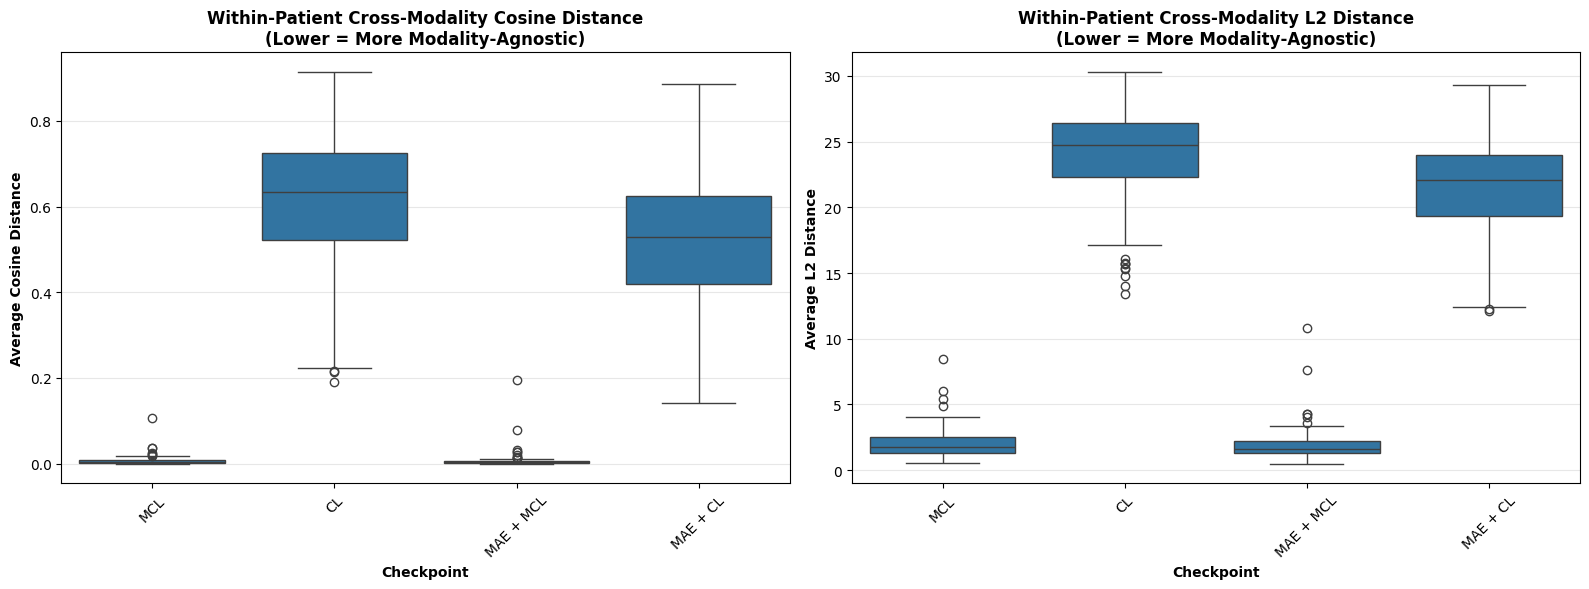

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

checkpoint_order = [checkpoint_labels[name] for name in checkpoint_names]

ax = axes[0]
sns.boxplot(data=df_within_patient, x='checkpoint', y='avg_cosine_distance', order=checkpoint_order, ax=ax)
ax.set_xlabel('Checkpoint', fontweight='bold')
ax.set_ylabel('Average Cosine Distance', fontweight='bold')
ax.set_title('Within-Patient Cross-Modality Cosine Distance\n(Lower = More Modality-Agnostic)', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1]
sns.boxplot(data=df_within_patient, x='checkpoint', y='avg_l2_distance', order=checkpoint_order, ax=ax)
ax.set_xlabel('Checkpoint', fontweight='bold')
ax.set_ylabel('Average L2 Distance', fontweight='bold')
ax.set_title('Within-Patient Cross-Modality L2 Distance\n(Lower = More Modality-Agnostic)', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(BASE_DIR / 'within_patient_cross_modality_distances.png', dpi=300, bbox_inches='tight')
print(f'Saved: {BASE_DIR / "within_patient_cross_modality_distances.png"}')
plt.show()

## Visualization: Bar Charts with Error Bars

Saved: /results/mgazda/embeddings_analysis/within_patient_distances_bar.png


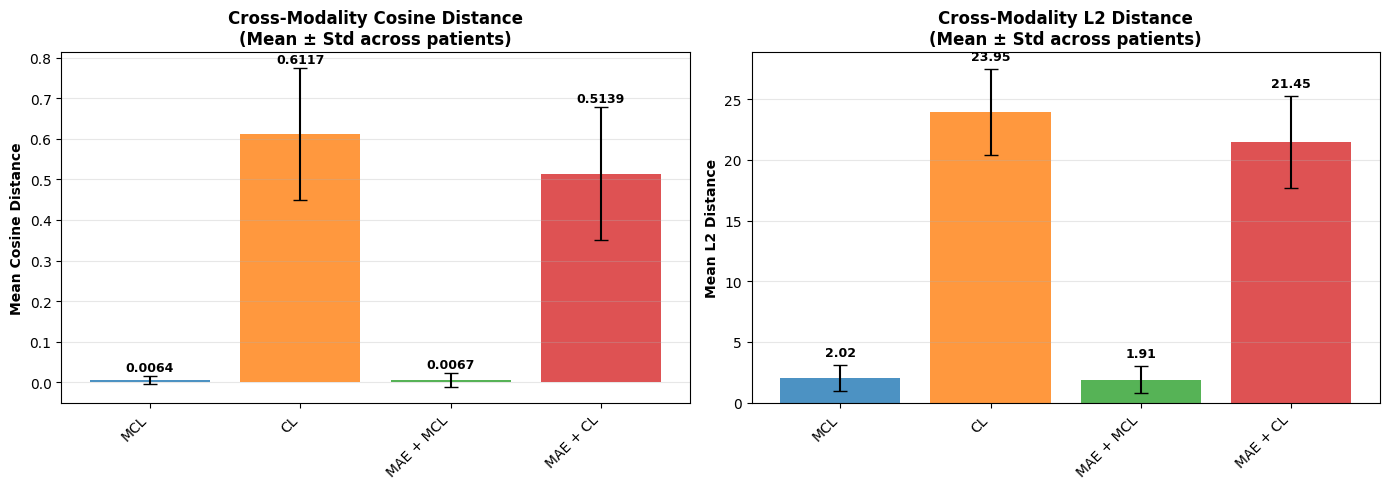

In [60]:
checkpoint_order = [checkpoint_labels[name] for name in checkpoint_names]
means_cosine = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_cosine_distance'].mean() for cp in checkpoint_order]
stds_cosine = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_cosine_distance'].std() for cp in checkpoint_order]
means_l2 = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_l2_distance'].mean() for cp in checkpoint_order]
stds_l2 = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_l2_distance'].std() for cp in checkpoint_order]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
x_pos = np.arange(len(checkpoint_order))
ax.bar(x_pos, means_cosine, yerr=stds_cosine, capsize=5, alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_xticks(x_pos)
ax.set_xticklabels(checkpoint_order, rotation=45, ha='right')
ax.set_ylabel('Mean Cosine Distance', fontweight='bold')
ax.set_title('Cross-Modality Cosine Distance\n(Mean ± Std across patients)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (mean, std) in enumerate(zip(means_cosine, stds_cosine)):
    ax.text(i, mean + std + 0.005, f'{mean:.4f}', ha='center', va='bottom', fontsize=9, weight='bold')

ax = axes[1]
ax.bar(x_pos, means_l2, yerr=stds_l2, capsize=5, alpha=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_xticks(x_pos)
ax.set_xticklabels(checkpoint_order, rotation=45, ha='right')
ax.set_ylabel('Mean L2 Distance', fontweight='bold')
ax.set_title('Cross-Modality L2 Distance\n(Mean ± Std across patients)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (mean, std) in enumerate(zip(means_l2, stds_l2)):
    ax.text(i, mean + std + 0.5, f'{mean:.2f}', ha='center', va='bottom', fontsize=9, weight='bold')

plt.tight_layout()
plt.savefig(BASE_DIR / 'within_patient_distances_bar.png', dpi=300, bbox_inches='tight')
print(f'Saved: {BASE_DIR / "within_patient_distances_bar.png"}')
plt.show()

## Save Results

In [61]:
output_path = BASE_DIR / 'within_patient_cross_modality_distances.csv'
df_within_patient.to_csv(output_path, index=False)
print(f'Saved detailed results to: {output_path}')
print(f'DataFrame shape: {df_within_patient.shape}')
print(f'Columns: {df_within_patient.columns.tolist()}')

Saved detailed results to: /results/mgazda/embeddings_analysis/within_patient_cross_modality_distances.csv
DataFrame shape: (588, 9)
Columns: ['checkpoint', 'patient_id', 'n_modalities', 'n_scans', 'n_cross_modality_pairs', 'avg_cosine_distance', 'std_cosine_distance', 'avg_l2_distance', 'std_l2_distance']


## Inter-Patient Same-Modality Distance Analysis (T1)

Compute distances between T1 scans from **different patients**.
This measures patient-specific representation:
- **Higher distance** = Better patient separation (good for downstream tasks)
- **Lower distance** = Patients look more similar (may indicate over-generalization)

In [62]:
# Analyze inter-patient distances for T1 modality
import random

MODALITY_TO_ANALYZE = 't1'  # Change this to analyze other modalities (flair, dwi, etc.)
MAX_PAIRS_PER_CHECKPOINT = 5000  # Limit pairs to avoid memory issues

inter_patient_results = []

for checkpoint_name in checkpoint_names:
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    print(f'Processing {checkpoint_labels[checkpoint_name]} for {MODALITY_TO_ANALYZE}...')
    
    # Get all T1 scans
    t1_mask = metadata['modality'] == MODALITY_TO_ANALYZE
    t1_data = metadata[t1_mask]
    
    if len(t1_data) == 0:
        print(f'  No {MODALITY_TO_ANALYZE} scans found, skipping...')
        continue
    
    print(f'  Found {len(t1_data)} {MODALITY_TO_ANALYZE} scans from {t1_data["patient_id"].nunique()} patients')
    
    # Get all pairwise distances between different patients
    cosine_distances = []
    l2_distances = []
    patient_pairs = []
    
    # Generate all possible pairs of different patients
    indices = t1_data.index.tolist()
    patient_ids = t1_data['patient_id'].values
    
    possible_pairs = [(i, j) for i in range(len(indices)) for j in range(i+1, len(indices)) 
                      if patient_ids[i] != patient_ids[j]]
    
    # Sample if too many pairs
    if len(possible_pairs) > MAX_PAIRS_PER_CHECKPOINT:
        print(f'  Sampling {MAX_PAIRS_PER_CHECKPOINT} from {len(possible_pairs)} possible pairs')
        possible_pairs = random.sample(possible_pairs, MAX_PAIRS_PER_CHECKPOINT)
    else:
        print(f'  Computing all {len(possible_pairs)} inter-patient pairs')
    
    for i, j in possible_pairs:
        idx_i = indices[i]
        idx_j = indices[j]
        
        # Compute distances
        emb_i = embeddings[idx_i:idx_i+1]
        emb_j = embeddings[idx_j:idx_j+1]
        
        cos_sim = cosine_similarity(emb_i, emb_j)[0, 0]
        cosine_distances.append(1 - cos_sim)
        l2_distances.append(np.linalg.norm(embeddings[idx_i] - embeddings[idx_j]))
    
    # Store results for this checkpoint
    inter_patient_results.append({
        'checkpoint': checkpoint_labels[checkpoint_name],
        'modality': MODALITY_TO_ANALYZE,
        'n_scans': len(t1_data),
        'n_patients': t1_data['patient_id'].nunique(),
        'n_pairs_analyzed': len(cosine_distances),
        'avg_cosine_distance': np.mean(cosine_distances),
        'std_cosine_distance': np.std(cosine_distances),
        'avg_l2_distance': np.mean(l2_distances),
        'std_l2_distance': np.std(l2_distances),
    })

df_inter_patient = pd.DataFrame(inter_patient_results)

print(f'\nCompleted inter-patient {MODALITY_TO_ANALYZE} analysis')
print(df_inter_patient)

Processing MCL for t1...
  Found 281 t1 scans from 90 patients
  Sampling 5000 from 38891 possible pairs
Processing CL for t1...
  Found 281 t1 scans from 90 patients
  Sampling 5000 from 38891 possible pairs
Processing MAE + MCL for t1...
  Found 281 t1 scans from 90 patients
  Sampling 5000 from 38891 possible pairs
Processing MAE + CL for t1...
  Found 281 t1 scans from 90 patients
  Sampling 5000 from 38891 possible pairs

Completed inter-patient t1 analysis
  checkpoint modality  n_scans  n_patients  n_pairs_analyzed  \
0        MCL       t1      281          90              5000   
1         CL       t1      281          90              5000   
2  MAE + MCL       t1      281          90              5000   
3   MAE + CL       t1      281          90              5000   

   avg_cosine_distance  std_cosine_distance  avg_l2_distance  std_l2_distance  
0             0.554768             0.267008        21.971041         6.930604  
1             0.649934             0.242478        2

## Summary: Inter-Patient T1 Distances

In [63]:
print('='*80)
print(f'INTER-PATIENT SAME-MODALITY DISTANCES ({MODALITY_TO_ANALYZE.upper()})')
print('='*80)
print('(Higher = Better patient separation)')
print('='*80)

for _, row in df_inter_patient.iterrows():
    print(f"\n{row['checkpoint']}:")
    print(f"  Cosine Distance: {row['avg_cosine_distance']:.4f} ± {row['std_cosine_distance']:.4f}")
    print(f"  L2 Distance:     {row['avg_l2_distance']:.4f} ± {row['std_l2_distance']:.4f}")
    print(f"  Scans analyzed: {row['n_scans']} from {row['n_patients']} patients")
    print(f"  Pairs computed: {row['n_pairs_analyzed']}")

print('\n' + '='*80)

# Find checkpoint with best patient separation
best_separation = df_inter_patient.loc[df_inter_patient['avg_cosine_distance'].idxmax()]
worst_separation = df_inter_patient.loc[df_inter_patient['avg_cosine_distance'].idxmin()]

print(f"\nBest patient separation (highest distance): {best_separation['checkpoint']}")
print(f"Worst patient separation (lowest distance): {worst_separation['checkpoint']}")

INTER-PATIENT SAME-MODALITY DISTANCES (T1)
(Higher = Better patient separation)

MCL:
  Cosine Distance: 0.5548 ± 0.2670
  L2 Distance:     21.9710 ± 6.9306
  Scans analyzed: 281 from 90 patients
  Pairs computed: 5000

CL:
  Cosine Distance: 0.6499 ± 0.2425
  L2 Distance:     24.2122 ± 5.5036
  Scans analyzed: 281 from 90 patients
  Pairs computed: 5000

MAE + MCL:
  Cosine Distance: 0.5430 ± 0.2532
  L2 Distance:     20.6314 ± 6.0948
  Scans analyzed: 281 from 90 patients
  Pairs computed: 5000

MAE + CL:
  Cosine Distance: 0.5851 ± 0.2467
  L2 Distance:     22.3772 ± 5.6751
  Scans analyzed: 281 from 90 patients
  Pairs computed: 5000


Best patient separation (highest distance): CL
Worst patient separation (lowest distance): MAE + MCL


## Visualization: Inter-Patient vs Within-Patient Comparison

Compare cross-modality (within-patient) vs same-modality (inter-patient) distances

Saved: /results/mgazda/embeddings_analysis/within_vs_inter_patient_t1.png


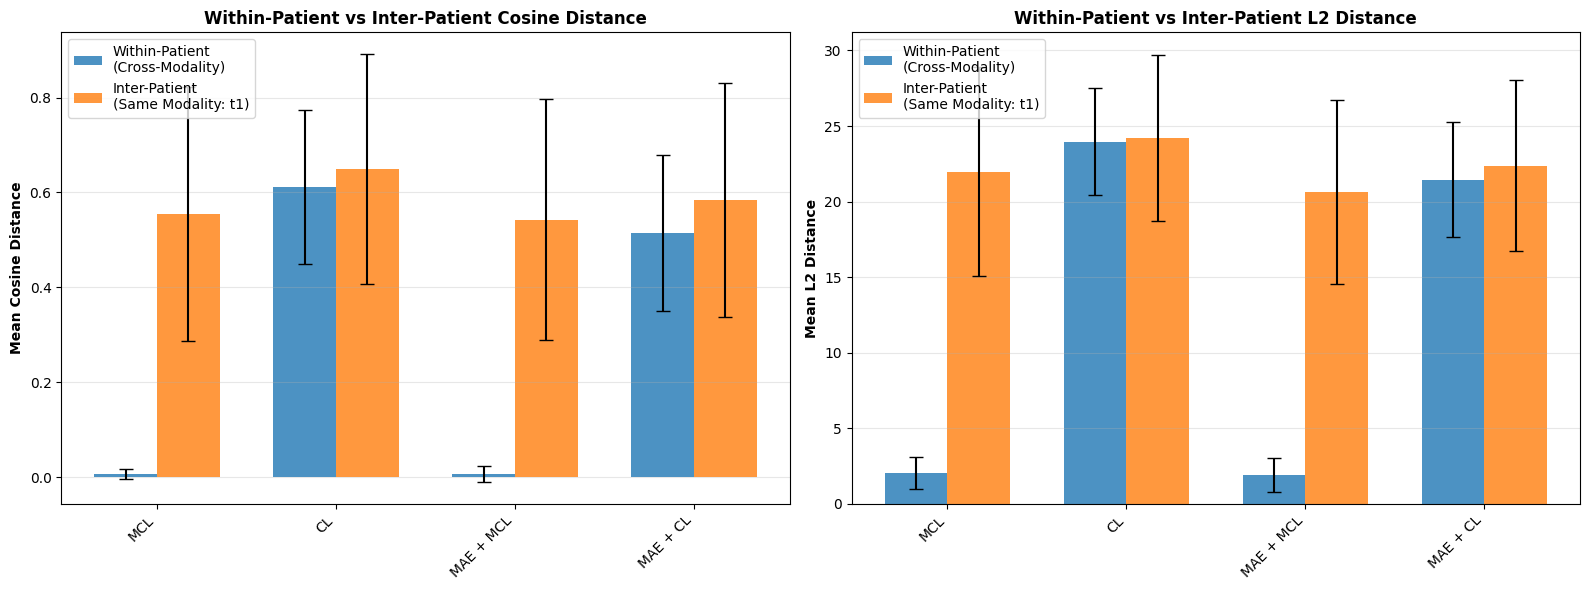

In [64]:
# Bar chart comparing within-patient cross-modality vs inter-patient same-modality distances
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

checkpoint_order = [checkpoint_labels[name] for name in checkpoint_names]

# Get within-patient means
within_means_cosine = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_cosine_distance'].mean() 
                       for cp in checkpoint_order]
within_stds_cosine = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_cosine_distance'].std() 
                      for cp in checkpoint_order]

# Get inter-patient means
inter_means_cosine = [df_inter_patient[df_inter_patient['checkpoint']==cp]['avg_cosine_distance'].values[0] 
                      if cp in df_inter_patient['checkpoint'].values else 0 
                      for cp in checkpoint_order]
inter_stds_cosine = [df_inter_patient[df_inter_patient['checkpoint']==cp]['std_cosine_distance'].values[0] 
                     if cp in df_inter_patient['checkpoint'].values else 0 
                     for cp in checkpoint_order]

# Plot 1: Cosine Distance Comparison
ax = axes[0]
x_pos = np.arange(len(checkpoint_order))
width = 0.35

ax.bar(x_pos - width/2, within_means_cosine, width, yerr=within_stds_cosine, 
       label='Within-Patient\n(Cross-Modality)', capsize=5, alpha=0.8, color='#1f77b4')
ax.bar(x_pos + width/2, inter_means_cosine, width, yerr=inter_stds_cosine,
       label=f'Inter-Patient\n(Same Modality: {MODALITY_TO_ANALYZE})', capsize=5, alpha=0.8, color='#ff7f0e')

ax.set_xticks(x_pos)
ax.set_xticklabels(checkpoint_order, rotation=45, ha='right')
ax.set_ylabel('Mean Cosine Distance', fontweight='bold')
ax.set_title('Within-Patient vs Inter-Patient Cosine Distance', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Same for L2 Distance
ax = axes[1]

within_means_l2 = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_l2_distance'].mean() 
                   for cp in checkpoint_order]
within_stds_l2 = [df_within_patient[df_within_patient['checkpoint']==cp]['avg_l2_distance'].std() 
                  for cp in checkpoint_order]

inter_means_l2 = [df_inter_patient[df_inter_patient['checkpoint']==cp]['avg_l2_distance'].values[0] 
                  if cp in df_inter_patient['checkpoint'].values else 0 
                  for cp in checkpoint_order]
inter_stds_l2 = [df_inter_patient[df_inter_patient['checkpoint']==cp]['std_l2_distance'].values[0] 
                 if cp in df_inter_patient['checkpoint'].values else 0 
                 for cp in checkpoint_order]

ax.bar(x_pos - width/2, within_means_l2, width, yerr=within_stds_l2,
       label='Within-Patient\n(Cross-Modality)', capsize=5, alpha=0.8, color='#1f77b4')
ax.bar(x_pos + width/2, inter_means_l2, width, yerr=inter_stds_l2,
       label=f'Inter-Patient\n(Same Modality: {MODALITY_TO_ANALYZE})', capsize=5, alpha=0.8, color='#ff7f0e')

ax.set_xticks(x_pos)
ax.set_xticklabels(checkpoint_order, rotation=45, ha='right')
ax.set_ylabel('Mean L2 Distance', fontweight='bold')
ax.set_title('Within-Patient vs Inter-Patient L2 Distance', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(BASE_DIR / f'within_vs_inter_patient_{MODALITY_TO_ANALYZE}.png', dpi=300, bbox_inches='tight')
print(f'Saved: {BASE_DIR / f"within_vs_inter_patient_{MODALITY_TO_ANALYZE}.png"}')
plt.show()

## Save Inter-Patient Results

In [65]:
output_path = BASE_DIR / f'inter_patient_{MODALITY_TO_ANALYZE}_distances.csv'
df_inter_patient.to_csv(output_path, index=False)
print(f'Saved inter-patient {MODALITY_TO_ANALYZE} results to: {output_path}')
print(f'DataFrame shape: {df_inter_patient.shape}')

Saved inter-patient t1 results to: /results/mgazda/embeddings_analysis/inter_patient_t1_distances.csv
DataFrame shape: (4, 9)


# t-SNE Visualizations

Dimensionality reduction to visualize the 768-dimensional embedding space in 2D.

In [66]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Set random seed for reproducibility
np.random.seed(42)

## 1. Modality Clustering Analysis

For each checkpoint, visualize how well modalities cluster together.
- **MCL/MAE+MCL** (modality contrastive): Should show well-mixed modalities
- **CL/MAE+CL** (regular contrastive): Might show more modality-specific clustering

Computing t-SNE for MCL...
Computing t-SNE for CL...
Computing t-SNE for MAE + MCL...
Computing t-SNE for MAE + CL...

Saved: /results/mgazda/embeddings_analysis/tsne_modality_clustering.png


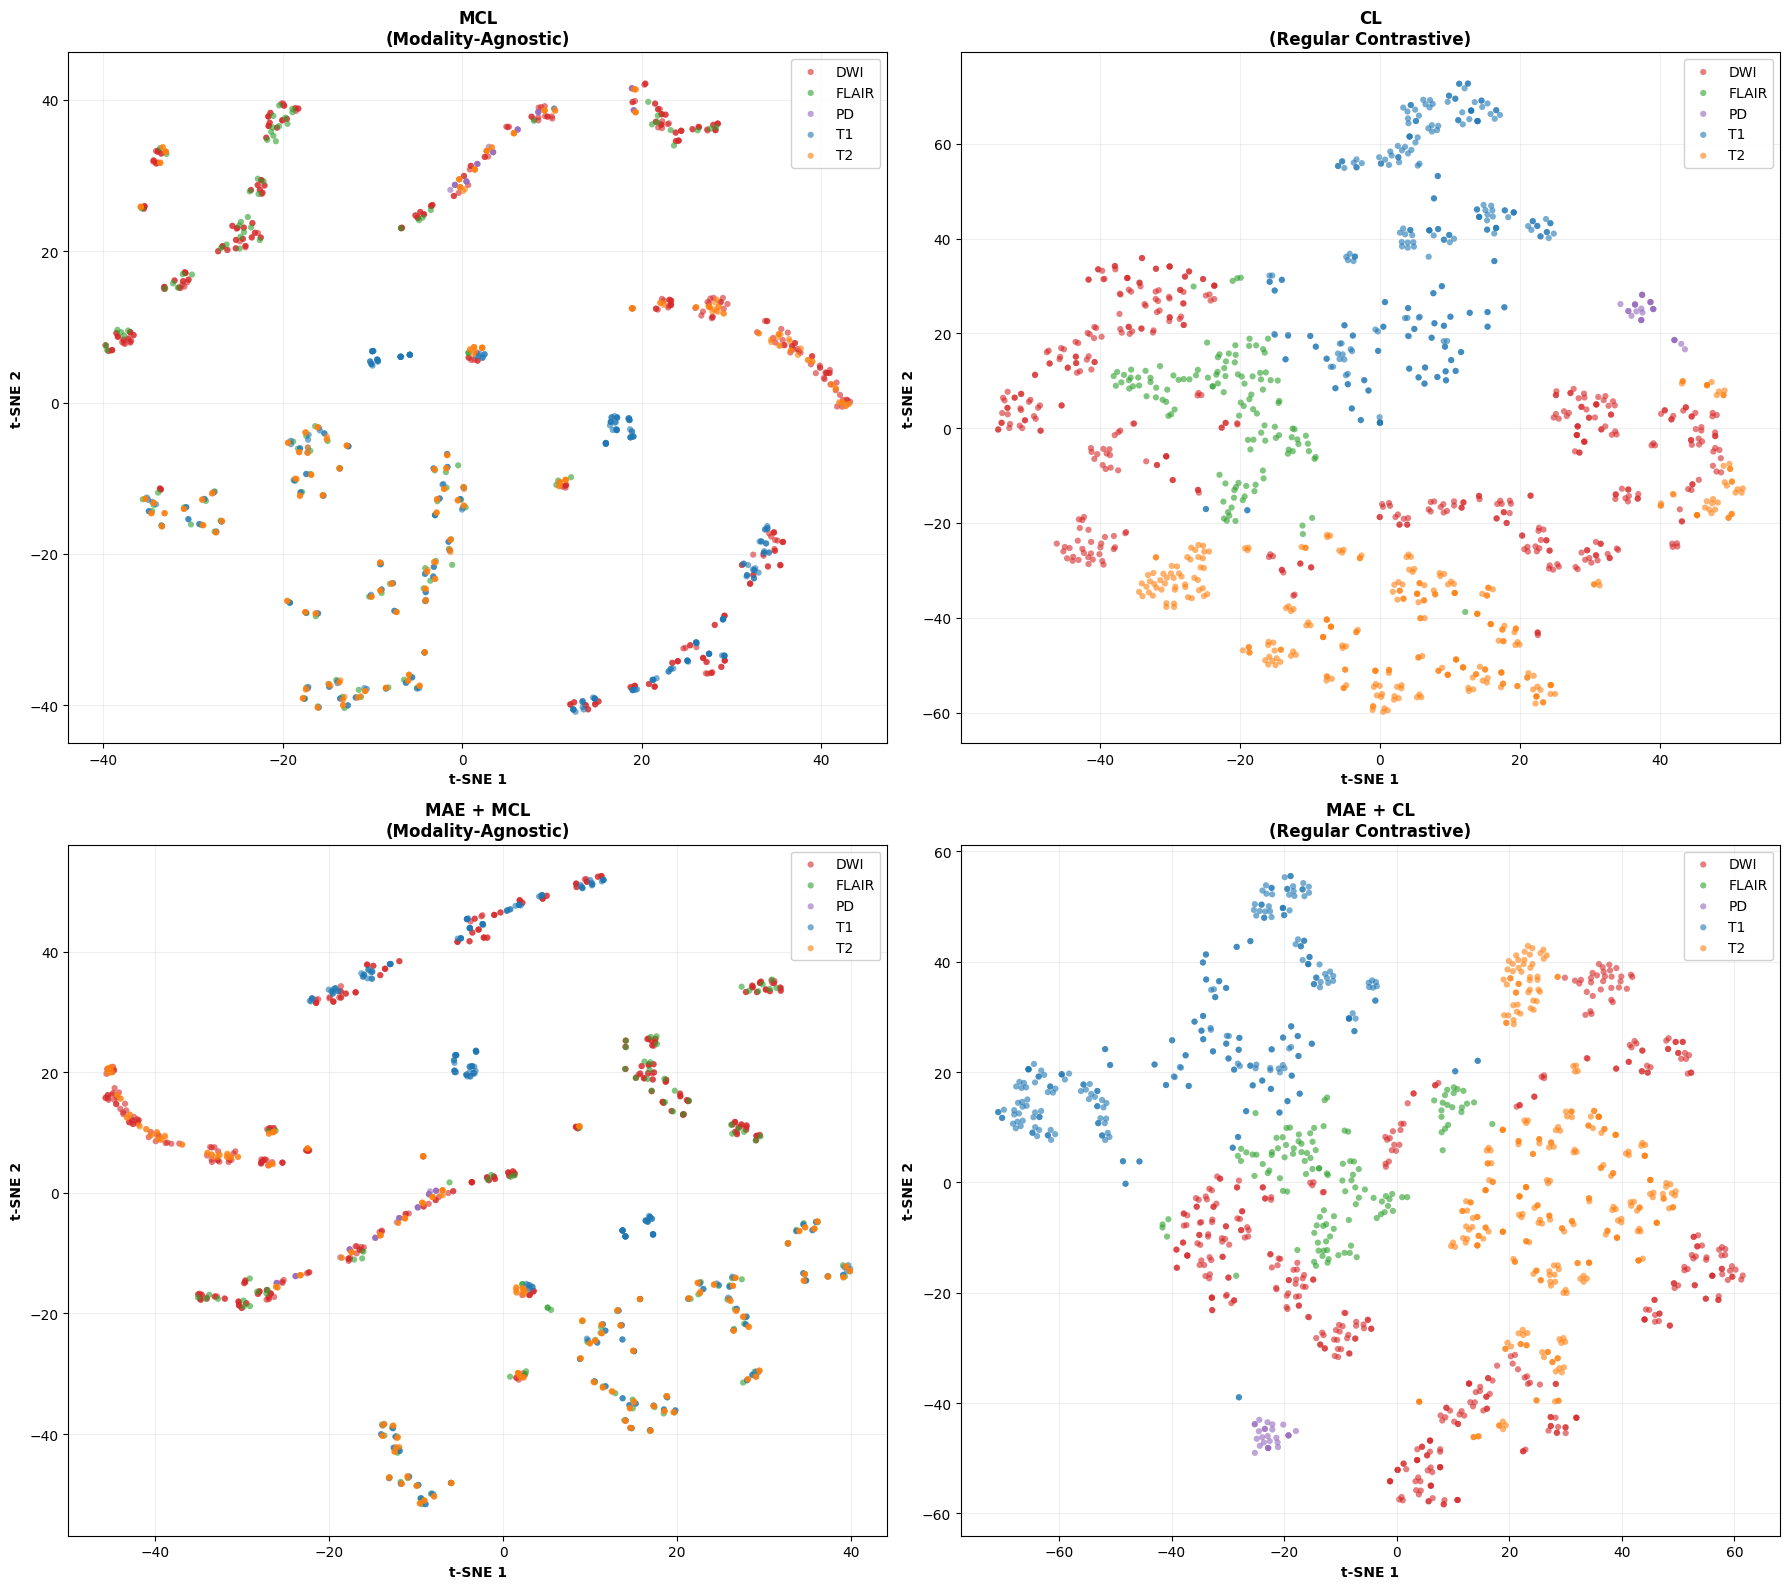

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

modality_colors = {
    't1': '#1f77b4',
    't2': '#ff7f0e', 
    'flair': '#2ca02c',
    'dwi': '#d62728',
    'pd': '#9467bd'
}

for idx, checkpoint_name in enumerate(checkpoint_names):
    print(f'Computing t-SNE for {checkpoint_labels[checkpoint_name]}...')
    
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    # Run t-SNE with dynamic perplexity
    perplexity = min(30, len(embeddings) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000, verbose=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot
    ax = axes[idx]
    
    for modality in sorted(metadata['modality'].unique()):
        mask = metadata['modality'] == modality
        ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                  c=modality_colors[modality], label=modality.upper(), 
                  alpha=0.6, s=20, edgecolors='none')
    
    ax.set_title(f'{checkpoint_labels[checkpoint_name]}\n({"Modality-Agnostic" if "MCL" in checkpoint_labels[checkpoint_name] else "Regular Contrastive"})',
                fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontweight='bold')
    ax.set_ylabel('t-SNE 2', fontweight='bold')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(BASE_DIR / 'tsne_modality_clustering.png', dpi=300, bbox_inches='tight')
print(f'\nSaved: {BASE_DIR / "tsne_modality_clustering.png"}')
plt.show()

## 2. Patient Clustering Analysis

Visualize patient-specific clustering (using subset of patients for clarity).

Computing patient t-SNE for MCL...
  Using 303 samples with perplexity=30


/tmp/ipykernel_90464/1329071729.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_TO_SHOW)


Computing patient t-SNE for CL...
  Using 303 samples with perplexity=30


/tmp/ipykernel_90464/1329071729.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_TO_SHOW)


Computing patient t-SNE for MAE + MCL...
  Using 303 samples with perplexity=30


/tmp/ipykernel_90464/1329071729.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_TO_SHOW)


Computing patient t-SNE for MAE + CL...
  Using 303 samples with perplexity=30


/tmp/ipykernel_90464/1329071729.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_TO_SHOW)



Saved: /results/mgazda/embeddings_analysis/tsne_patient_clustering.png


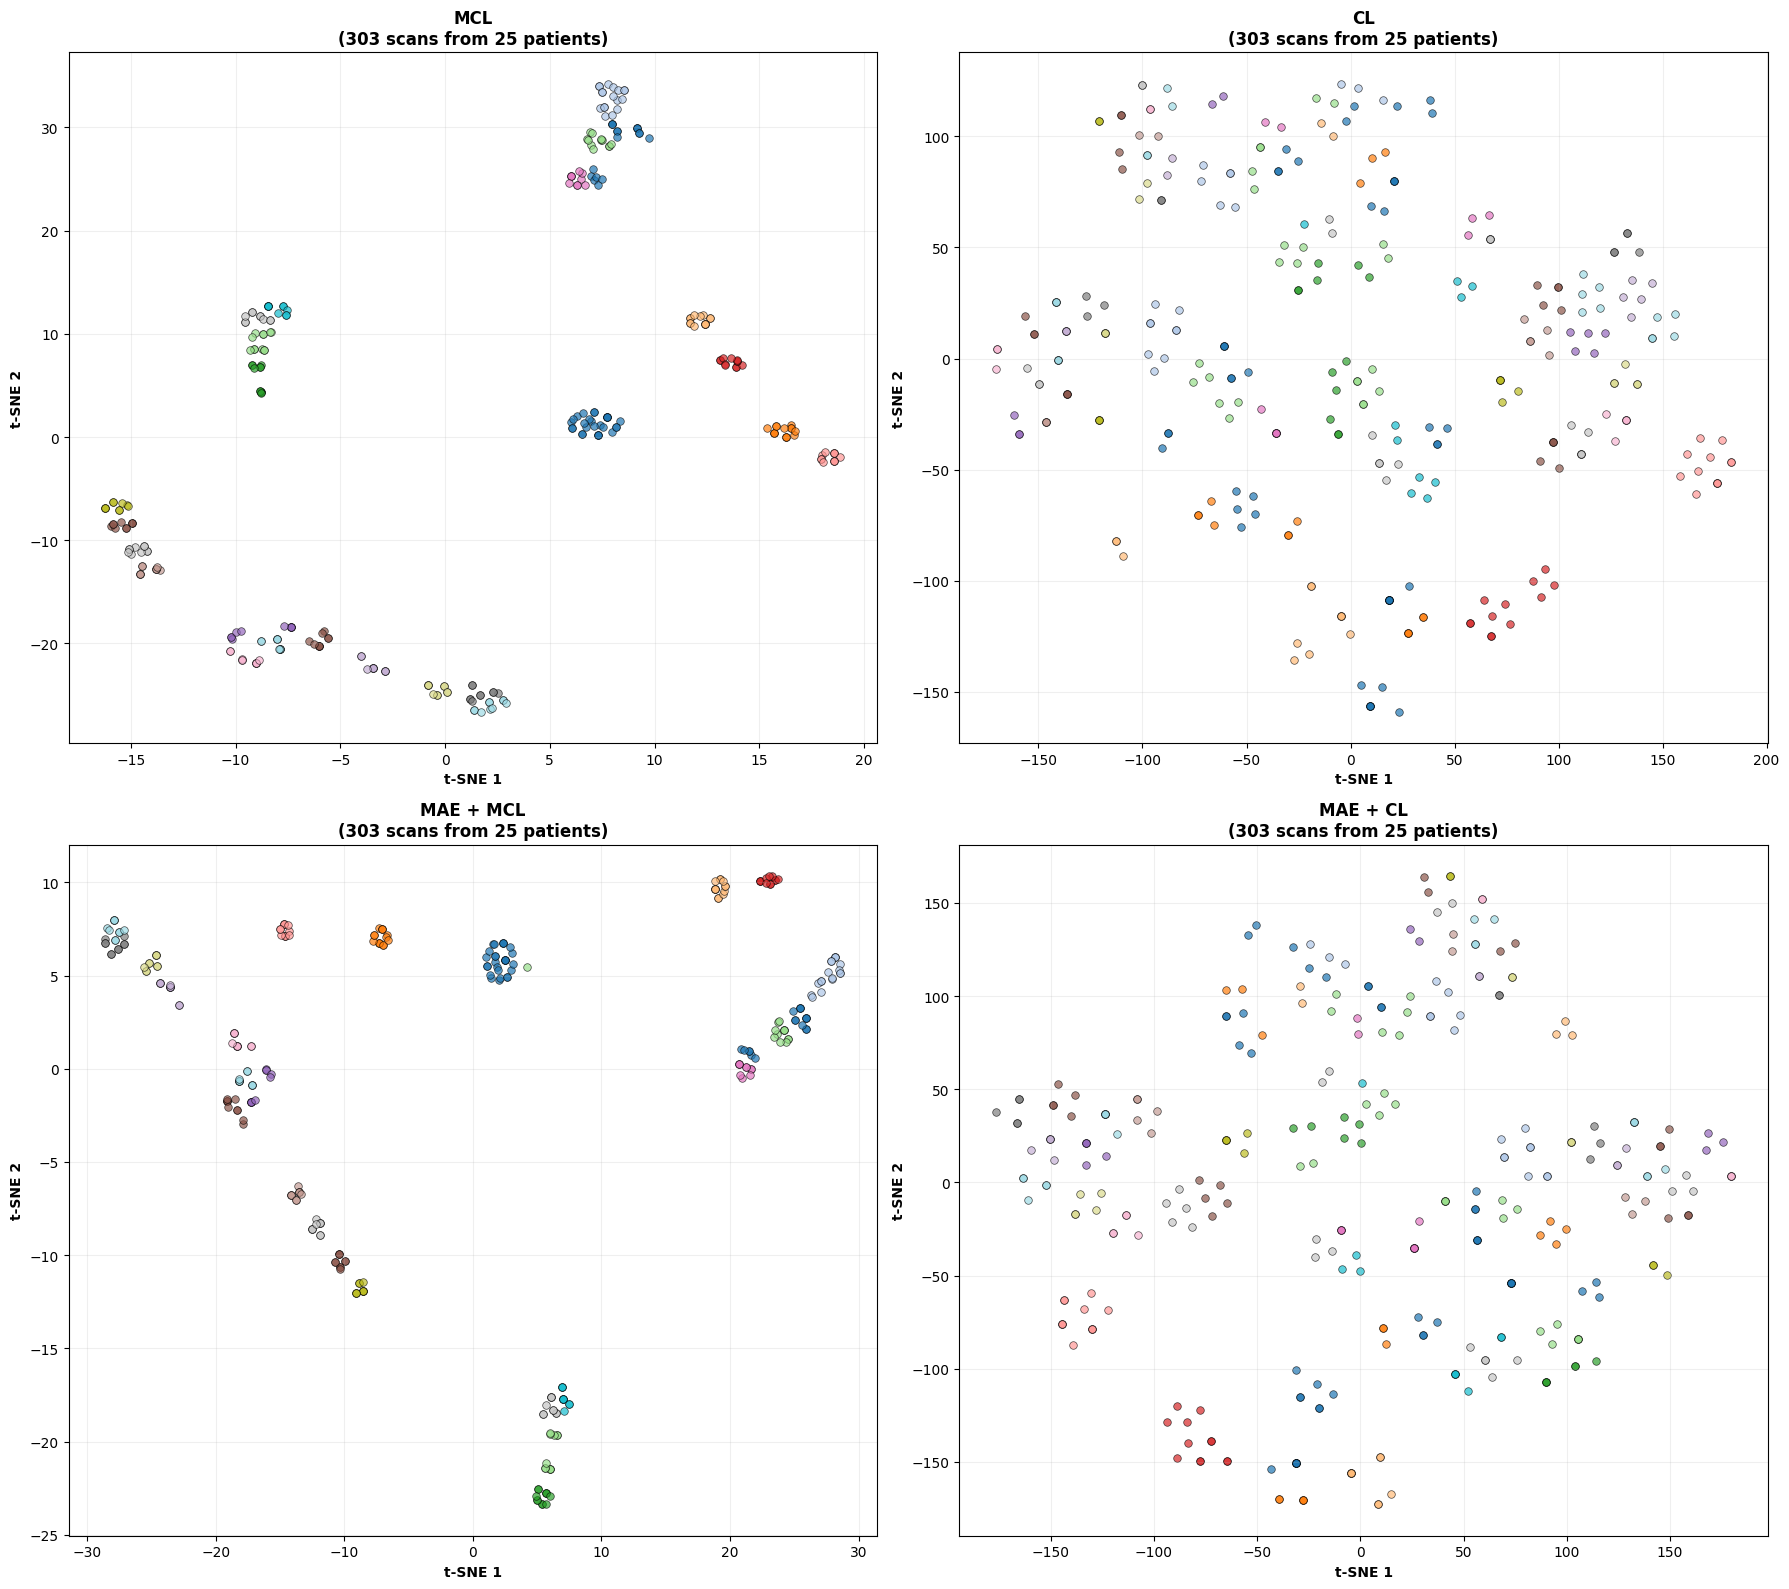

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

# Select patients with most scans for better visualization
N_PATIENTS_TO_SHOW = 25

for idx, checkpoint_name in enumerate(checkpoint_names):
    print(f'Computing patient t-SNE for {checkpoint_labels[checkpoint_name]}...')
    
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    # Select top N patients by number of scans
    patient_counts = metadata['patient_id'].value_counts()
    top_patients = patient_counts.head(N_PATIENTS_TO_SHOW).index.tolist()
    
    # Filter to these patients
    mask = metadata['patient_id'].isin(top_patients)
    embeddings_subset = embeddings[mask]
    metadata_subset = metadata[mask].reset_index(drop=True)
    
    # Run t-SNE with dynamic perplexity
    perplexity = min(30, max(5, len(embeddings_subset) - 1))
    print(f'  Using {len(embeddings_subset)} samples with perplexity={perplexity}')
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000, verbose=0)
    embeddings_2d = tsne.fit_transform(embeddings_subset)
    
    # Plot with unique color per patient
    ax = axes[idx]
    
    # Use a colormap
    cmap = plt.cm.get_cmap('tab20', N_PATIENTS_TO_SHOW)
    patient_to_color = {patient: cmap(i) for i, patient in enumerate(top_patients)}
    
    for patient_id in top_patients:
        patient_mask = metadata_subset['patient_id'] == patient_id
        ax.scatter(embeddings_2d[patient_mask, 0], embeddings_2d[patient_mask, 1],
                  c=[patient_to_color[patient_id]], s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_title(f'{checkpoint_labels[checkpoint_name]}\n({len(metadata_subset)} scans from {N_PATIENTS_TO_SHOW} patients)',
                fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontweight='bold')
    ax.set_ylabel('t-SNE 2', fontweight='bold')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(BASE_DIR / 'tsne_patient_clustering.png', dpi=300, bbox_inches='tight')
print(f'\nSaved: {BASE_DIR / "tsne_patient_clustering.pdf"}')
plt.show()

In [ ]:
# Patient Clustering Analysis: MCL vs CL (2 rows)
fig, axes = plt.subplots(2, 1, figsize=(10, 14))

# Select patients with most scans for better visualization
N_PATIENTS_TO_SHOW = 25

# Only MCL and CL
checkpoints_to_plot = ['mcl', 'cl']

for idx, checkpoint_name in enumerate(checkpoints_to_plot):
    print(f'Computing patient t-SNE for {checkpoint_labels[checkpoint_name]}...')
    
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    # Select top N patients by number of scans
    patient_counts = metadata['patient_id'].value_counts()
    top_patients = patient_counts.head(N_PATIENTS_TO_SHOW).index.tolist()
    
    # Filter to these patients
    mask = metadata['patient_id'].isin(top_patients)
    embeddings_subset = embeddings[mask]
    metadata_subset = metadata[mask].reset_index(drop=True)
    
    # Run t-SNE with dynamic perplexity
    perplexity = min(30, max(5, len(embeddings_subset) - 1))
    print(f'  Using {len(embeddings_subset)} samples with perplexity={perplexity}')
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000, verbose=0)
    embeddings_2d = tsne.fit_transform(embeddings_subset)
    
    # Plot with unique color per patient
    ax = axes[idx]
    
    # Use a colormap
    cmap = plt.cm.get_cmap('tab20', N_PATIENTS_TO_SHOW)
    patient_to_color = {patient: cmap(i) for i, patient in enumerate(top_patients)}
    
    for patient_id in top_patients:
        patient_mask = metadata_subset['patient_id'] == patient_id
        ax.scatter(embeddings_2d[patient_mask, 0], embeddings_2d[patient_mask, 1],
                  c=[patient_to_color[patient_id]], s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_title(f'{checkpoint_labels[checkpoint_name]}\n({len(metadata_subset)} scans from {N_PATIENTS_TO_SHOW} patients)',
                fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontweight='bold')
    ax.set_ylabel('t-SNE 2', fontweight='bold')
    ax.grid(True, alpha=0.2)
    
    # Add simple legend indicating color scheme
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='gray', edgecolor='black', label='Each color = 1 patient')]
    ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.savefig(BASE_DIR / 'tsne_patient_clustering_mcl_vs_cl.pdf', dpi=300, bbox_inches='tight')
print(f'\nSaved: {BASE_DIR / "tsne_patient_clustering_mcl_vs_cl.pdf"}')
plt.show()

## 3. Combined 4-Checkpoint Comparison

All checkpoints on the same plot to compare embedding space structure.

Computing t-SNE for all 4636 embeddings across 4 checkpoints...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4636 samples in 0.001s...
[t-SNE] Computed neighbors for 4636 samples in 0.168s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4636
[t-SNE] Computed conditional probabilities for sample 2000 / 4636
[t-SNE] Computed conditional probabilities for sample 3000 / 4636
[t-SNE] Computed conditional probabilities for sample 4000 / 4636
[t-SNE] Computed conditional probabilities for sample 4636 / 4636
[t-SNE] Mean sigma: 6.520630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.192257
[t-SNE] KL divergence after 1000 iterations: 0.411520
Saved: /results/mgazda/embeddings_analysis/tsne_combined_checkpoints.png


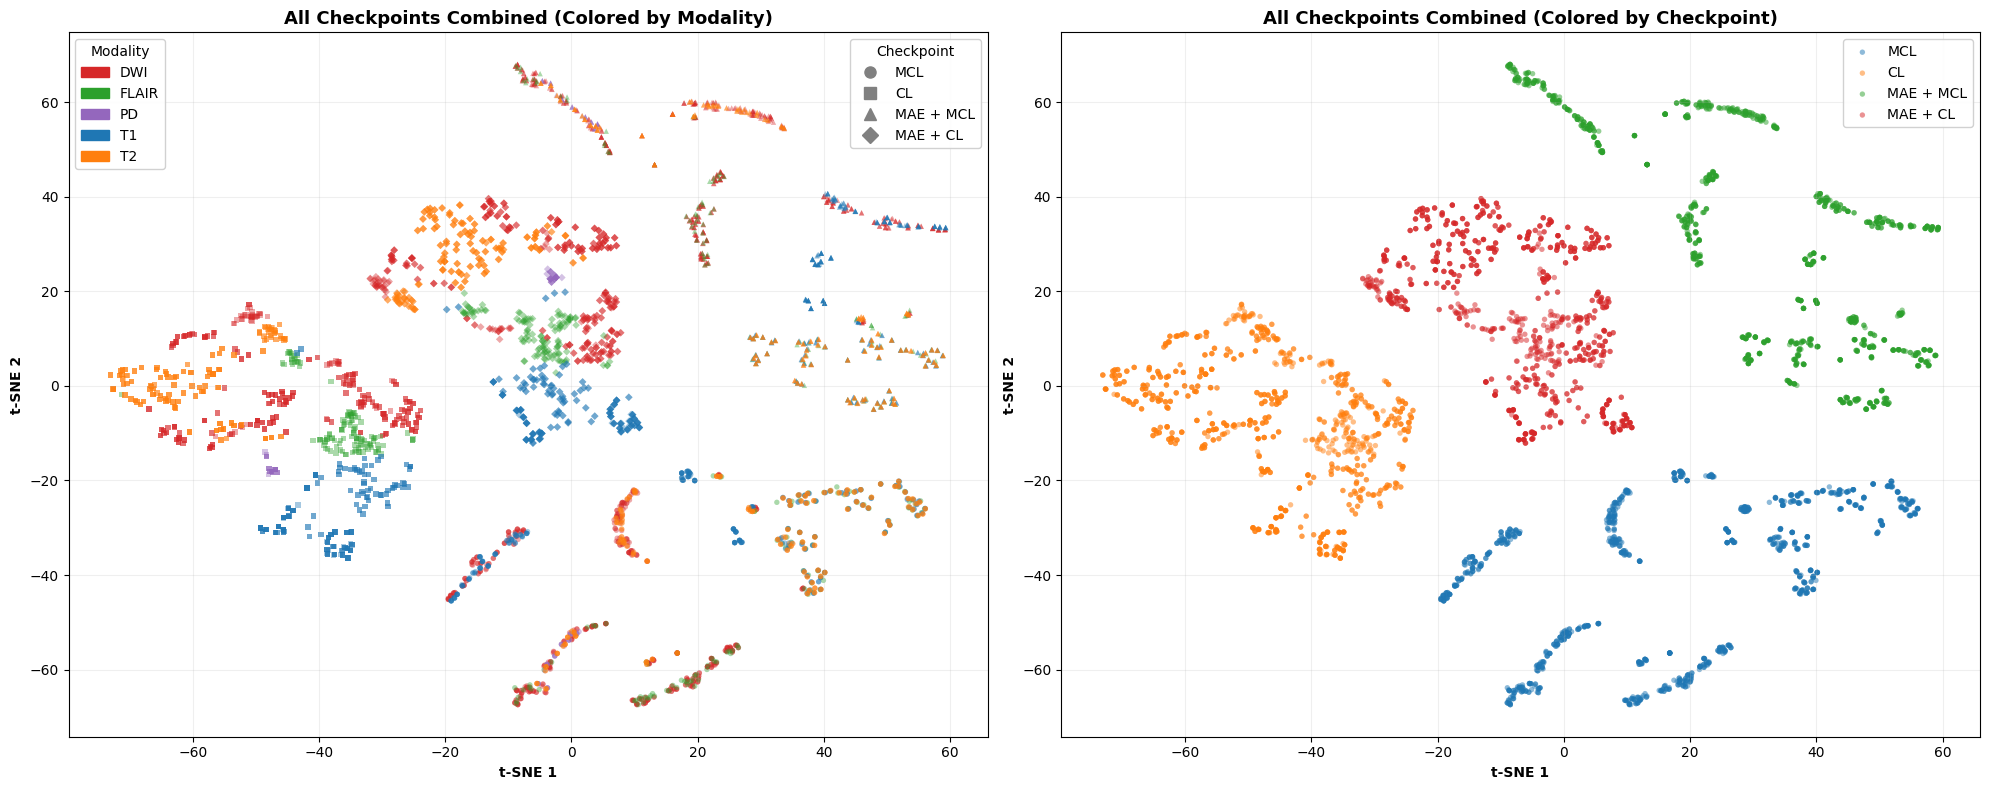

In [69]:
# Combine all embeddings
all_embeddings = []
all_modalities = []
all_checkpoints = []

for checkpoint_name in checkpoint_names:
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    all_embeddings.append(embeddings)
    all_modalities.extend(metadata['modality'].tolist())
    all_checkpoints.extend([checkpoint_labels[checkpoint_name]] * len(embeddings))

all_embeddings = np.vstack(all_embeddings)

print(f'Computing t-SNE for all {len(all_embeddings)} embeddings across 4 checkpoints...')
perplexity = min(50, len(all_embeddings) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000, verbose=1)
embeddings_2d_combined = tsne.fit_transform(all_embeddings)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Colored by modality, shaped by checkpoint
ax = axes[0]
markers = {'MCL': 'o', 'CL': 's', 'MAE + MCL': '^', 'MAE + CL': 'D'}

for checkpoint in [checkpoint_labels[name] for name in checkpoint_names]:
    for modality in sorted(set(all_modalities)):
        mask = [(m == modality and c == checkpoint) for m, c in zip(all_modalities, all_checkpoints)]
        ax.scatter(embeddings_2d_combined[mask, 0], embeddings_2d_combined[mask, 1],
                  c=modality_colors[modality], marker=markers[checkpoint], 
                  label=f'{modality.upper()} ({checkpoint})' if modality == 't1' and checkpoint == 'MCL' else '',
                  alpha=0.4, s=15, edgecolors='none')

# Custom legend
modality_patches = [mpatches.Patch(color=modality_colors[m], label=m.upper()) for m in sorted(modality_colors.keys())]
marker_lines = [plt.Line2D([0], [0], marker=markers[ckpt], color='gray', linestyle='', 
                           markersize=8, label=ckpt) for ckpt in markers.keys()]
legend1 = ax.legend(handles=modality_patches, loc='upper left', title='Modality', framealpha=0.9)
ax.add_artist(legend1)
ax.legend(handles=marker_lines, loc='upper right', title='Checkpoint', framealpha=0.9)

ax.set_title('All Checkpoints Combined (Colored by Modality)', fontweight='bold', fontsize=13)
ax.set_xlabel('t-SNE 1', fontweight='bold')
ax.set_ylabel('t-SNE 2', fontweight='bold')
ax.grid(True, alpha=0.2)

# Plot 2: Colored by checkpoint
ax = axes[1]
checkpoint_colors = {'MCL': '#1f77b4', 'CL': '#ff7f0e', 'MAE + MCL': '#2ca02c', 'MAE + CL': '#d62728'}

for checkpoint in [checkpoint_labels[name] for name in checkpoint_names]:
    mask = [c == checkpoint for c in all_checkpoints]
    ax.scatter(embeddings_2d_combined[mask, 0], embeddings_2d_combined[mask, 1],
              c=checkpoint_colors[checkpoint], label=checkpoint,
              alpha=0.5, s=15, edgecolors='none')

ax.set_title('All Checkpoints Combined (Colored by Checkpoint)', fontweight='bold', fontsize=13)
ax.set_xlabel('t-SNE 1', fontweight='bold')
ax.set_ylabel('t-SNE 2', fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(BASE_DIR / 'tsne_combined_checkpoints.png', dpi=300, bbox_inches='tight')
print(f'Saved: {BASE_DIR / "tsne_combined_checkpoints.png"}')
plt.show()

## 4. Patient Trajectory Visualization

For patients with multiple modalities, draw lines connecting their scans.
- **Compact trajectories** = Patient-specific clustering
- **Spread-out trajectories** = Modality overrides patient identity

Computing trajectories for MCL...
  Using 28 samples with perplexity=27
Computing trajectories for CL...
  Using 28 samples with perplexity=27
Computing trajectories for MAE + MCL...
  Using 28 samples with perplexity=27


/tmp/ipykernel_90464/3308769354.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(selected_patients))
/tmp/ipykernel_90464/3308769354.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(selected_patients))
/tmp/ipykernel_90464/3308769354.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(selected_patients))


Computing trajectories for MAE + CL...
  Using 28 samples with perplexity=27


/tmp/ipykernel_90464/3308769354.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(selected_patients))



Saved: /results/mgazda/embeddings_analysis/tsne_patient_trajectories.png


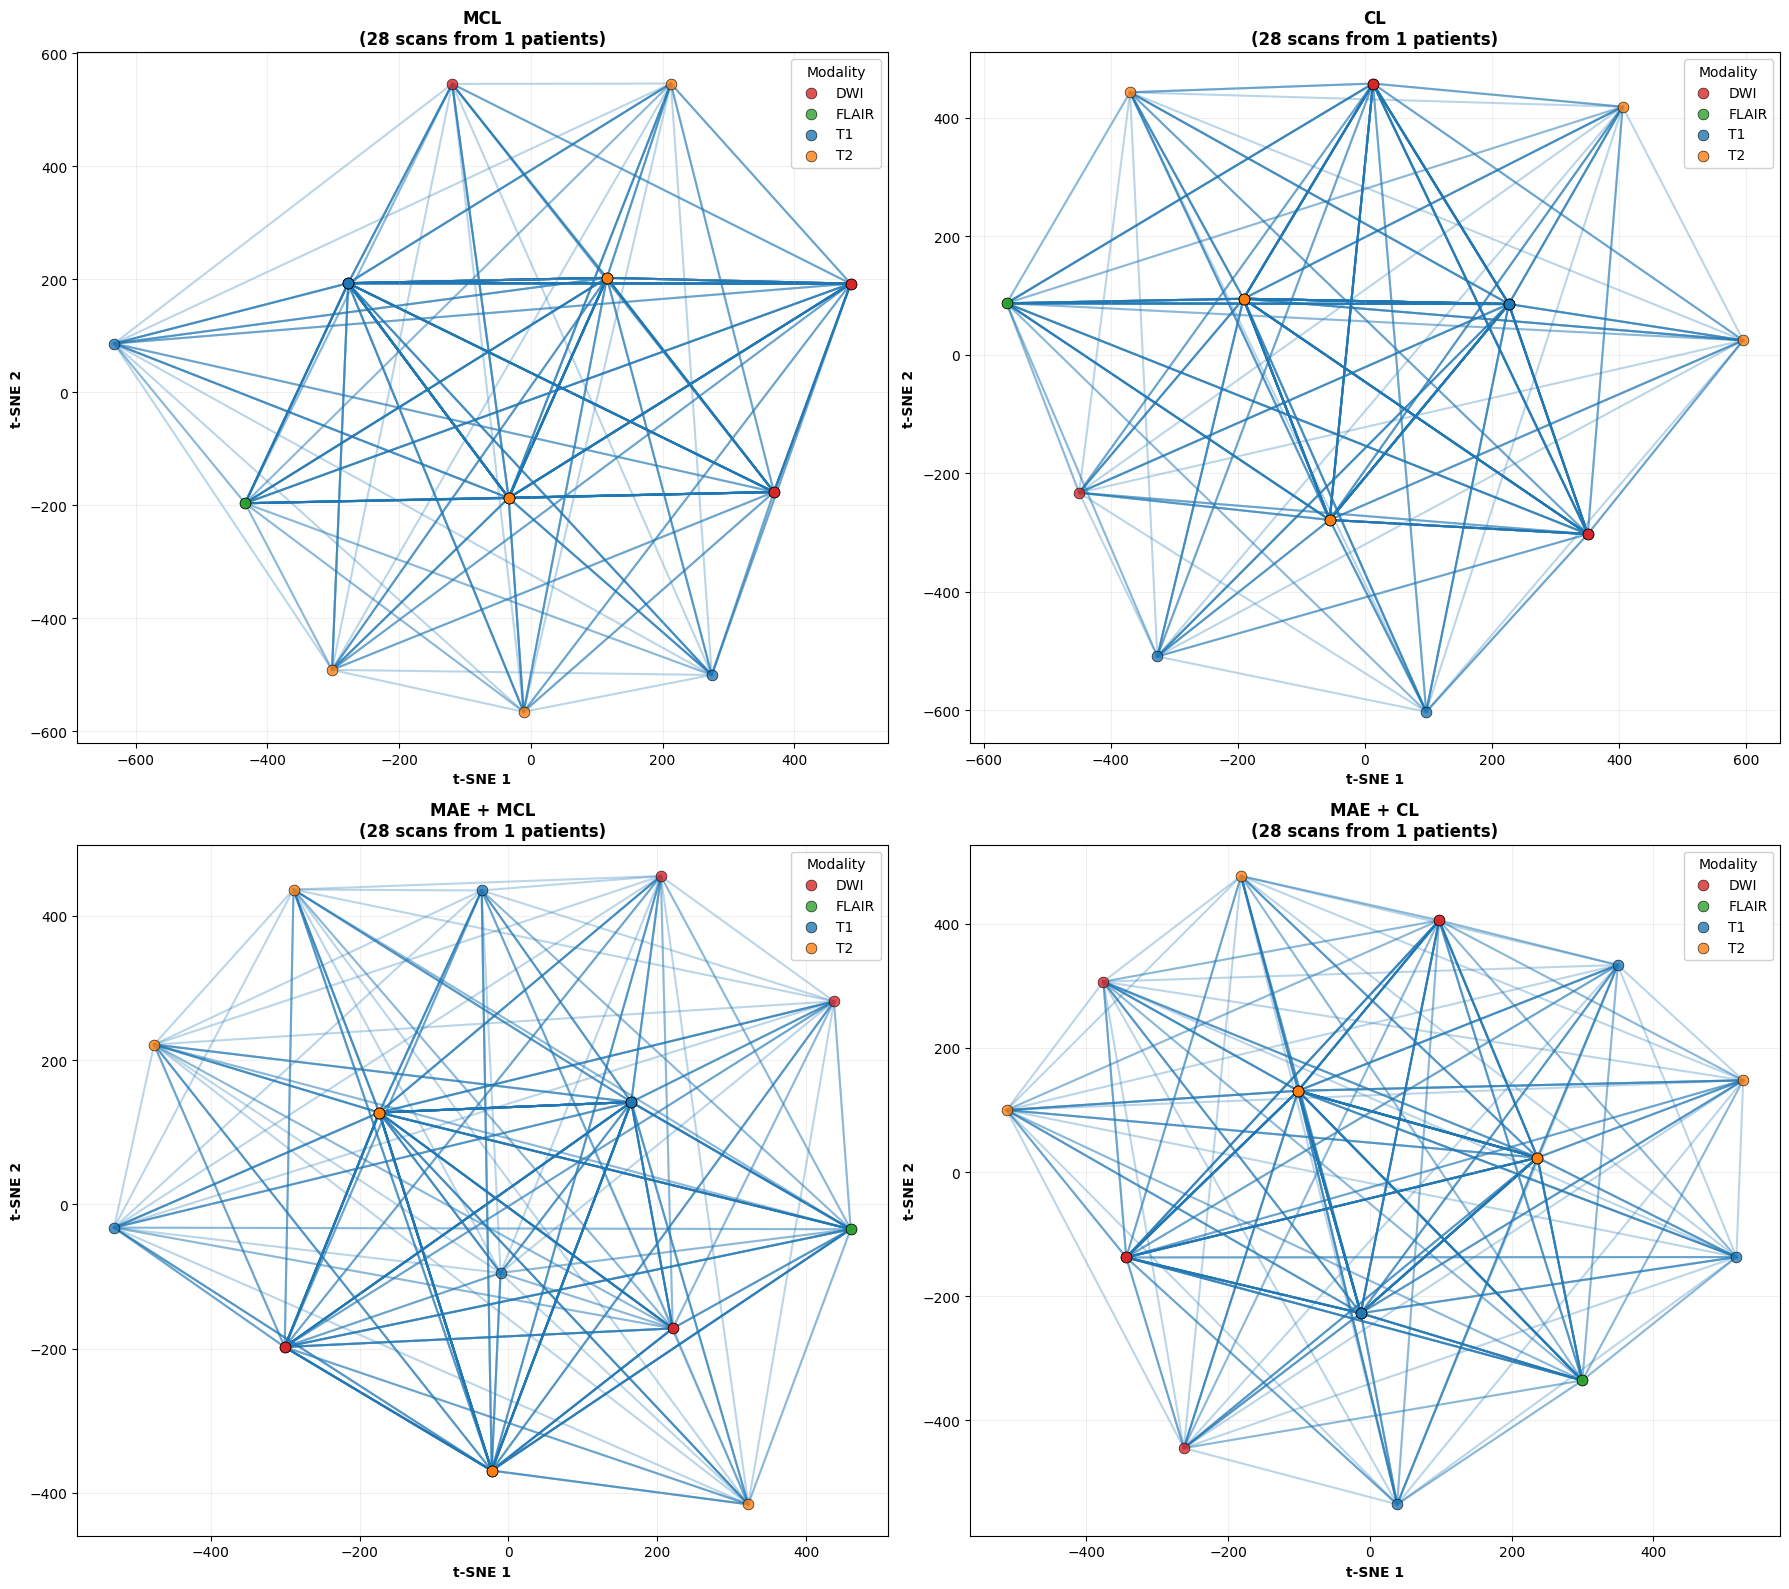

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

# Select patients with 4+ modalities for better trajectories
MIN_MODALITIES = 4
N_PATIENTS_TO_SHOW = 20

for idx, checkpoint_name in enumerate(checkpoint_names):
    print(f'Computing trajectories for {checkpoint_labels[checkpoint_name]}...')
    
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    # Find patients with multiple modalities
    patient_modality_counts = metadata.groupby('patient_id')['modality'].nunique()
    multi_modality_patients = patient_modality_counts[patient_modality_counts >= MIN_MODALITIES].index.tolist()
    
    # Select top N by total scans
    patient_scan_counts = metadata[metadata['patient_id'].isin(multi_modality_patients)]['patient_id'].value_counts()
    selected_patients = patient_scan_counts.head(N_PATIENTS_TO_SHOW).index.tolist()
    
    # Filter data
    mask = metadata['patient_id'].isin(selected_patients)
    embeddings_subset = embeddings[mask]
    metadata_subset = metadata[mask].reset_index(drop=True)
    
    # Run t-SNE with dynamic perplexity
    perplexity = min(30, max(5, len(embeddings_subset) - 1))
    print(f'  Using {len(embeddings_subset)} samples with perplexity={perplexity}')
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000, verbose=0)
    embeddings_2d = tsne.fit_transform(embeddings_subset)
    
    # Plot
    ax = axes[idx]
    
    # Color palette for patients
    cmap = plt.cm.get_cmap('tab20', len(selected_patients))
    patient_to_color = {patient: cmap(i) for i, patient in enumerate(selected_patients)}
    
    # Plot points colored by modality
    for modality in sorted(metadata_subset['modality'].unique()):
        modality_mask = metadata_subset['modality'] == modality
        ax.scatter(embeddings_2d[modality_mask, 0], embeddings_2d[modality_mask, 1],
                  c=modality_colors[modality], label=modality.upper(),
                  alpha=0.8, s=60, edgecolors='black', linewidth=0.5, zorder=3)
    
    # Draw trajectories (lines connecting same patient's scans)
    for patient_id in selected_patients:
        patient_mask = metadata_subset['patient_id'] == patient_id
        patient_coords = embeddings_2d[patient_mask]
        
        if len(patient_coords) > 1:
            # Draw lines between all pairs of this patient's scans
            from itertools import combinations as comb
            for i, j in comb(range(len(patient_coords)), 2):
                ax.plot([patient_coords[i, 0], patient_coords[j, 0]],
                       [patient_coords[i, 1], patient_coords[j, 1]],
                       c=patient_to_color[patient_id], alpha=0.3, linewidth=1.5, zorder=1)
    
    ax.set_title(f'{checkpoint_labels[checkpoint_name]}\n({len(metadata_subset)} scans from {len(selected_patients)} patients)',
                fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontweight='bold')
    ax.set_ylabel('t-SNE 2', fontweight='bold')
    ax.legend(loc='best', framealpha=0.9, title='Modality')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(BASE_DIR / 'tsne_patient_trajectories.png', dpi=300, bbox_inches='tight')
print(f'\nSaved: {BASE_DIR / "tsne_patient_trajectories.png"}')
plt.show()

## 5. Modality-Specific Comparison (T1 Only)

Focus on T1 scans only, colored by patient to show patient separation quality.
This complements the inter-patient T1 distance analysis.

Computing t1 t-SNE for MCL...
  Using 281 samples with perplexity=30


/tmp/ipykernel_90464/2389160548.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_HIGHLIGHT)


Computing t1 t-SNE for CL...
  Using 281 samples with perplexity=30


/tmp/ipykernel_90464/2389160548.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_HIGHLIGHT)


Computing t1 t-SNE for MAE + MCL...
  Using 281 samples with perplexity=30


/tmp/ipykernel_90464/2389160548.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_HIGHLIGHT)


Computing t1 t-SNE for MAE + CL...
  Using 281 samples with perplexity=30


/tmp/ipykernel_90464/2389160548.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N_PATIENTS_HIGHLIGHT)



Saved: /results/mgazda/embeddings_analysis/tsne_t1_patient_separation.png


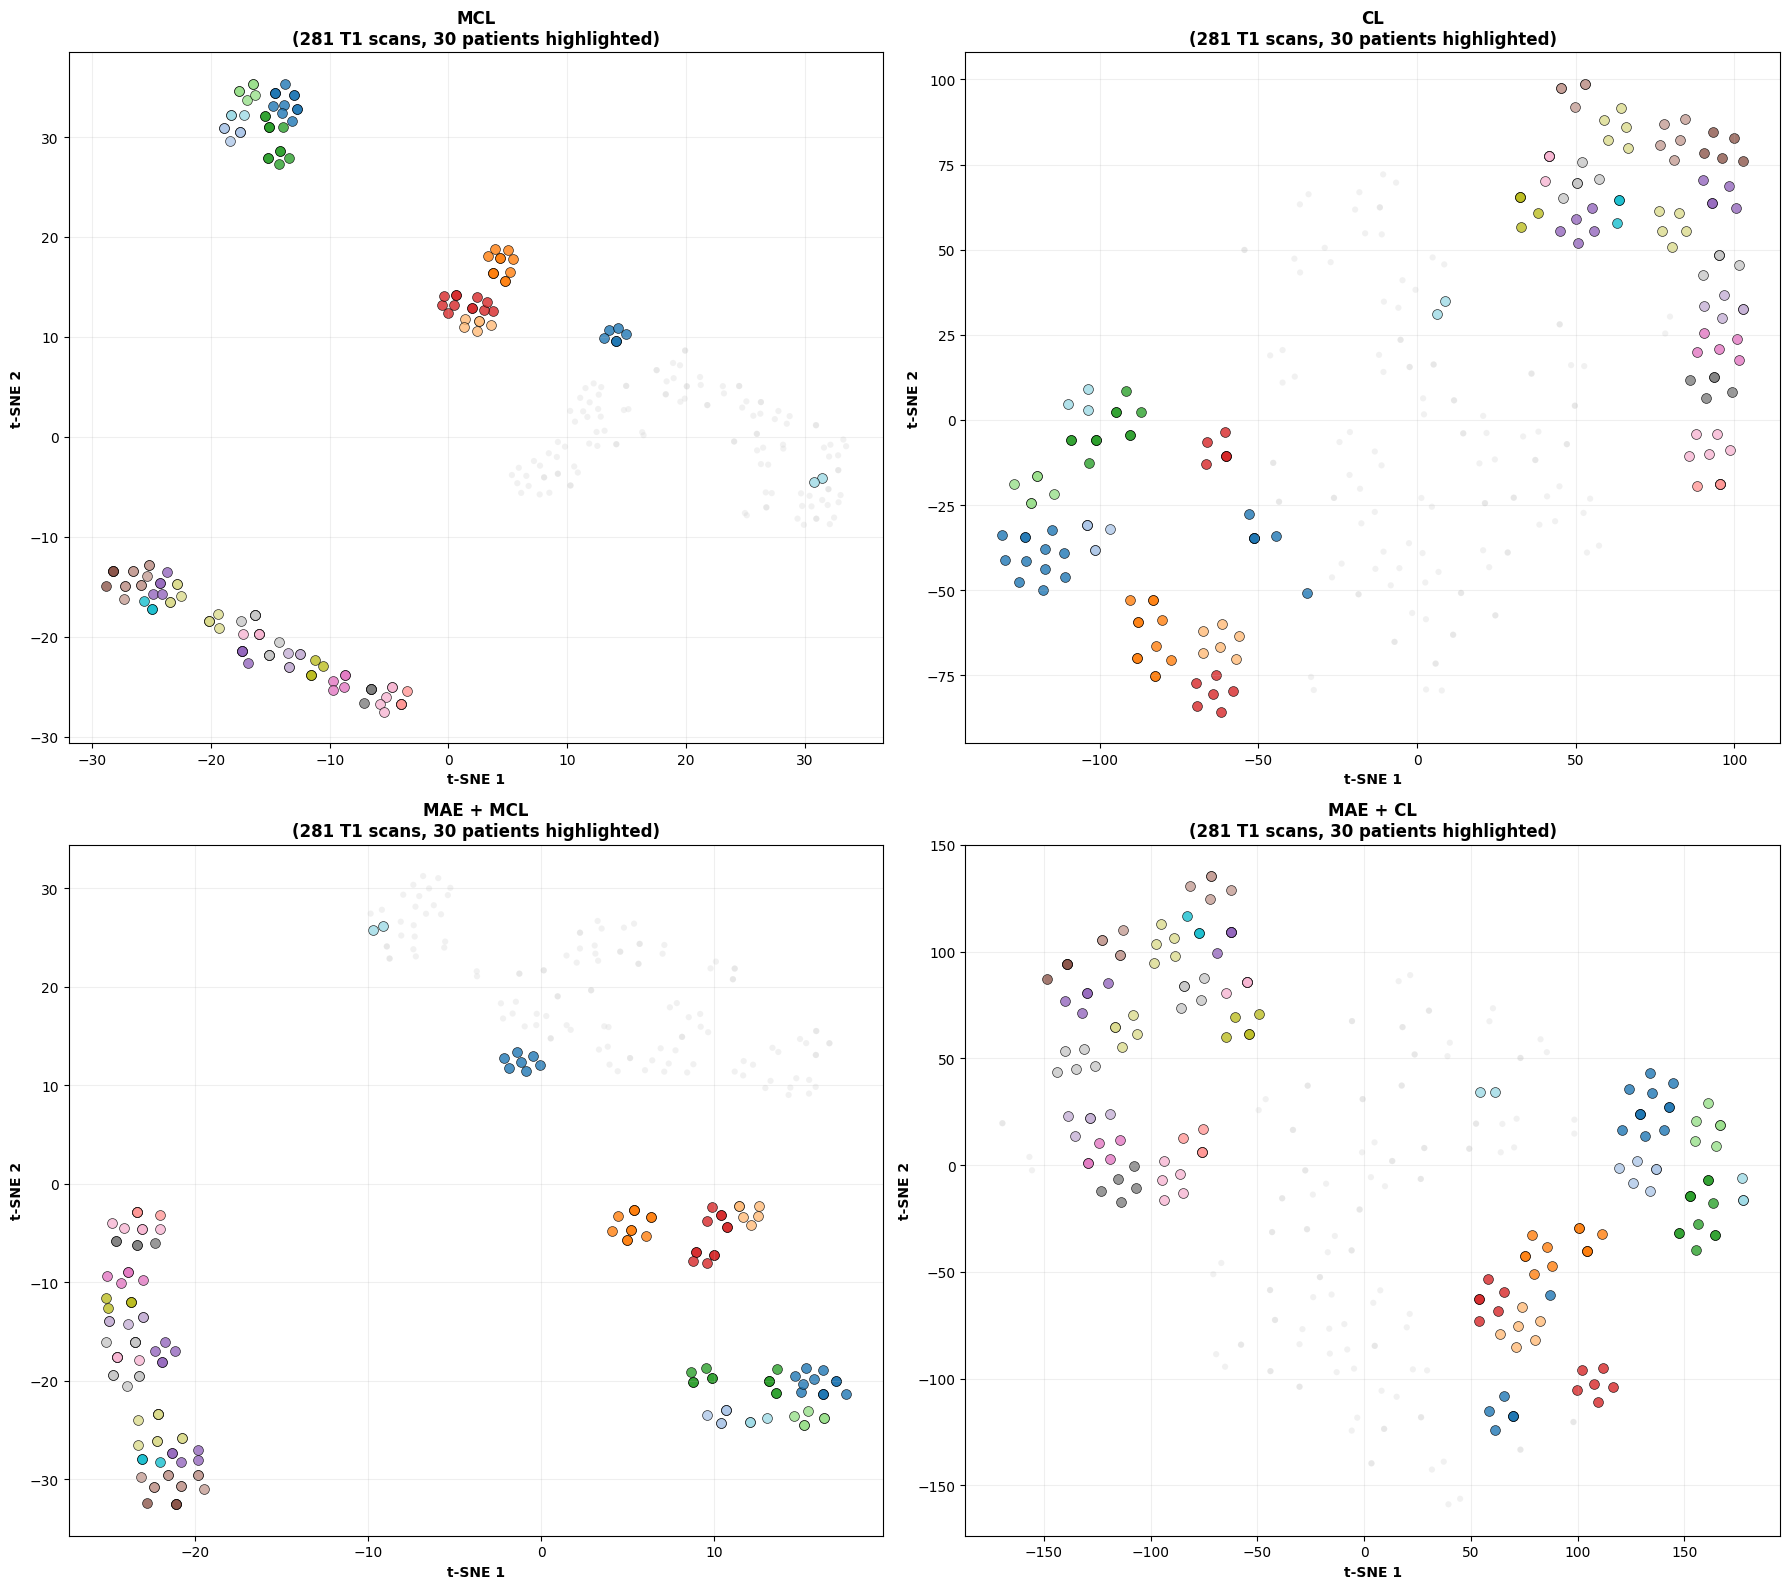

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

MODALITY_FOCUS = 't1'
N_PATIENTS_HIGHLIGHT = 30  # Highlight specific patients

for idx, checkpoint_name in enumerate(checkpoint_names):
    print(f'Computing {MODALITY_FOCUS} t-SNE for {checkpoint_labels[checkpoint_name]}...')
    
    embeddings = embeddings_dict[checkpoint_name].numpy()
    metadata = metadata_dict[checkpoint_name]
    
    # Filter to T1 scans only
    t1_mask = metadata['modality'] == MODALITY_FOCUS
    embeddings_t1 = embeddings[t1_mask]
    metadata_t1 = metadata[t1_mask].reset_index(drop=True)
    
    # Select patients with most T1 scans to highlight
    patient_counts = metadata_t1['patient_id'].value_counts()
    highlighted_patients = patient_counts.head(N_PATIENTS_HIGHLIGHT).index.tolist()
    
    # Run t-SNE with dynamic perplexity
    perplexity = min(30, max(5, len(embeddings_t1) - 1))
    print(f'  Using {len(embeddings_t1)} samples with perplexity={perplexity}')
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000, verbose=0)
    embeddings_2d = tsne.fit_transform(embeddings_t1)
    
    # Plot
    ax = axes[idx]
    
    # Plot non-highlighted patients in gray
    other_mask = ~metadata_t1['patient_id'].isin(highlighted_patients)
    ax.scatter(embeddings_2d[other_mask, 0], embeddings_2d[other_mask, 1],
              c='lightgray', alpha=0.3, s=20, edgecolors='none', label='Other patients')
    
    # Plot highlighted patients with unique colors
    cmap = plt.cm.get_cmap('tab20', N_PATIENTS_HIGHLIGHT)
    patient_to_color = {patient: cmap(i) for i, patient in enumerate(highlighted_patients)}
    
    for patient_id in highlighted_patients:
        patient_mask = metadata_t1['patient_id'] == patient_id
        ax.scatter(embeddings_2d[patient_mask, 0], embeddings_2d[patient_mask, 1],
                  c=[patient_to_color[patient_id]], s=50, alpha=0.8, 
                  edgecolors='black', linewidth=0.5)
    
    ax.set_title(f'{checkpoint_labels[checkpoint_name]}\n({len(embeddings_t1)} {MODALITY_FOCUS.upper()} scans, {N_PATIENTS_HIGHLIGHT} patients highlighted)',
                fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontweight='bold')
    ax.set_ylabel('t-SNE 2', fontweight='bold')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(BASE_DIR / f'tsne_{MODALITY_FOCUS}_patient_separation.png', dpi=300, bbox_inches='tight')
print(f'\nSaved: {BASE_DIR / f"tsne_{MODALITY_FOCUS}_patient_separation.png"}')
plt.show()